Processing: 100%|██████████| 300/300 [4:13:44<00:00, 50.75s/it]  


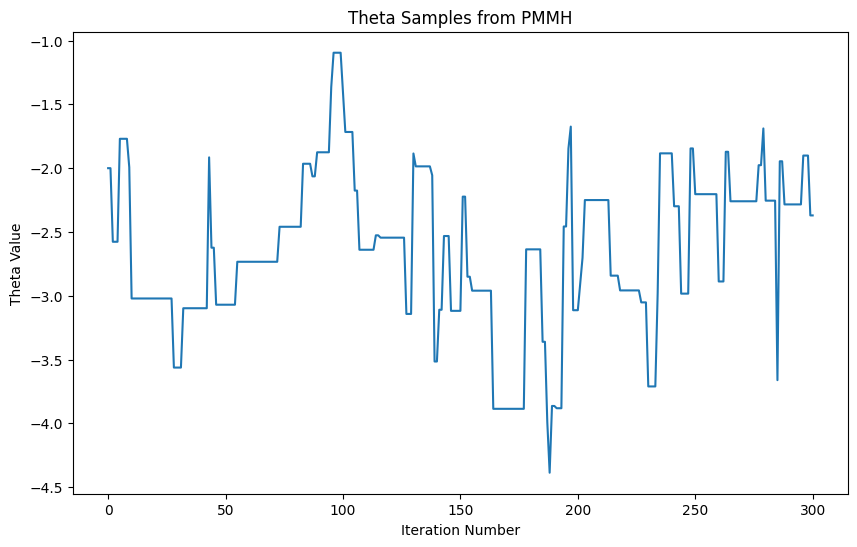

Mean of theta: -2.6401955394150924
Median of theta: -2.636163269080383
95% confidence interval of theta: [-3.88588419 -1.70248556]


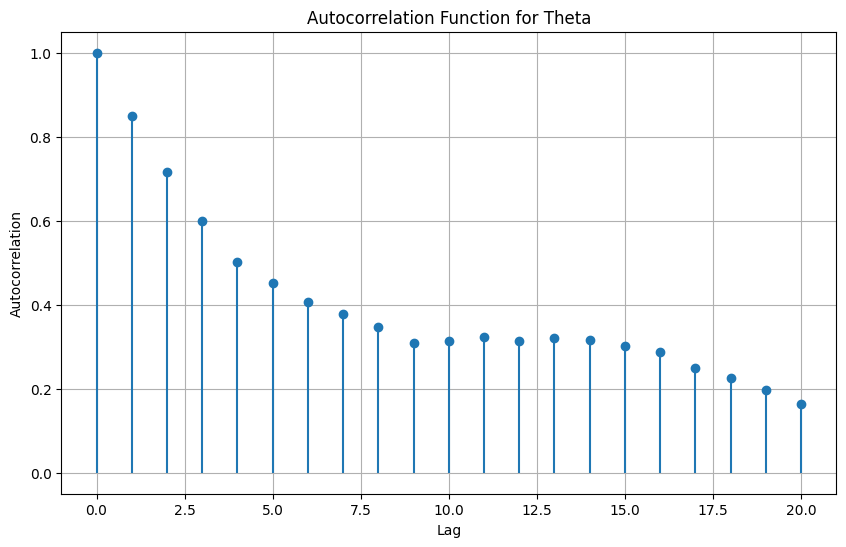

Estimated Autocorrelation Time: 16.151239734206353


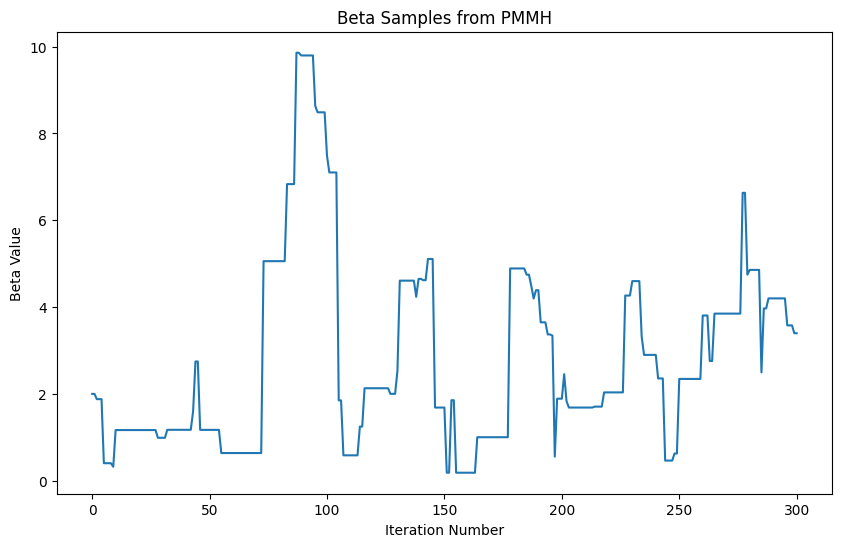

Mean of beta: 2.8008794519434366
Median of beta: 2.0343266131547995
95% confidence interval of beta: [0.18388859 9.21576728]


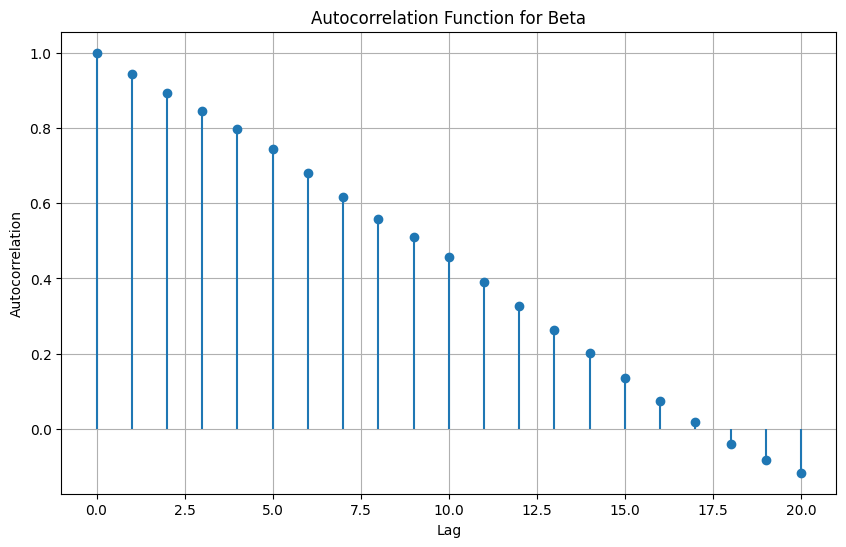

Estimated Autocorrelation Time: 17.43196874530872


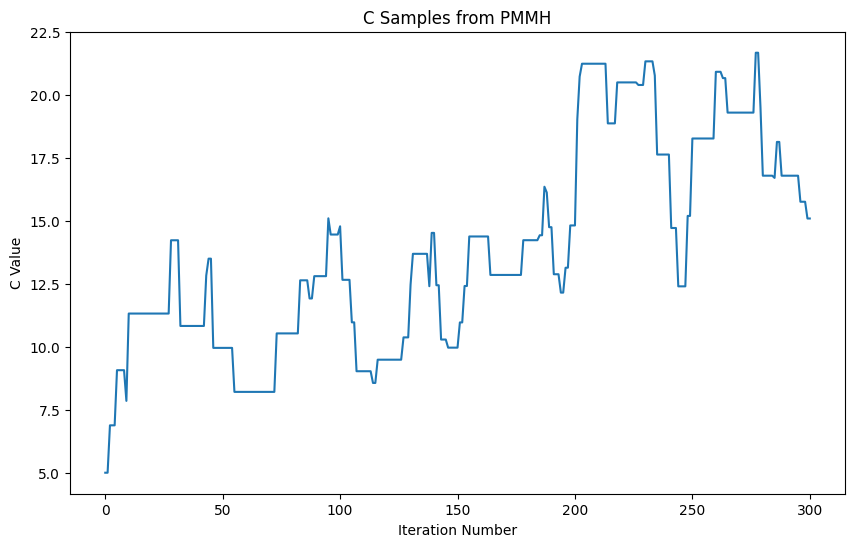

Mean of C: 13.820715775644928
Median of C: 12.851280538398482
95% confidence interval of C: [ 8.20886513 21.23600342]


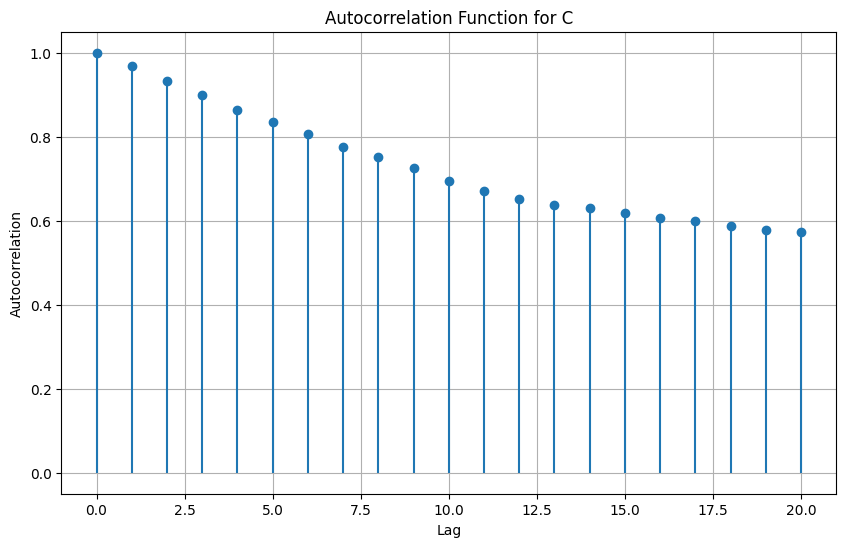

Estimated Autocorrelation Time: 29.818953248582297


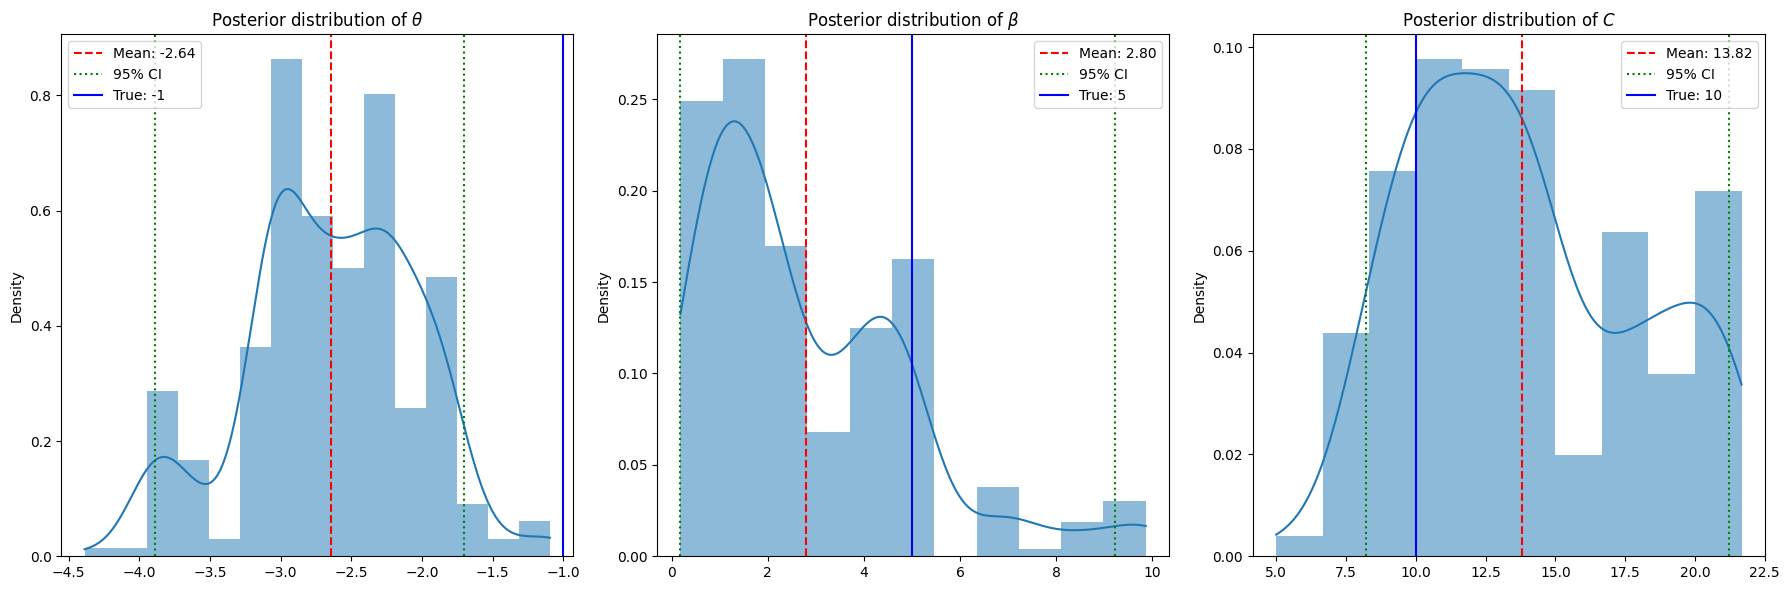

In [4]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 300 #Number of iterations
theta0 = -2 #Initial guess of theta
beta0 = 2 #Initial Guess of beta
C0 = 5  #Initial Guess of C  
num_particles = 1000

#The 3 step sizes for the 3 parameters
l_theta = 1 
l_beta = 2
l_C = 2





true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

true_beta = 5
true_C = 10
T = 10


N = 10 * T  # Resolution, 10 points per unit time now

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(true_beta, true_C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form


#The collection of the parameter samples
theta_samples = [theta0]
C_samples = [C0]
beta_samples = [beta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        sigmaw_uncertainties = []

        

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            alphaw = weighted_sum(alphaws,weights)
            betaw = weighted_sum(betaws,weights)
            sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            sigmaw_uncertainties.append(sigmaw_uncertainty)


            incremental_normal_gamma_generator = normal_gamma_process(beta_samples[-1], C_samples[-1], dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False





    #####################################################################################################################################################################################################################################################
    #From here, we propose a the parameter samples, indepndent parameter assumed

    theta_proposed = theta_samples[-1] + np.random.randn() * l_theta
    beta_proposed = beta_samples[-1] + np.random.randn() * l_beta
    C_proposed = C_samples[-1] + np.random.randn() * l_C
    #Note that the Gamma process parameters have to be positive
    if beta_proposed <=0:
        beta_proposed = 0.000001
    if C_proposed <= 0:
        C_proposeed = 0.000001
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta_proposed, C_proposed, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        beta_samples.append(beta_proposed)
        C_samples.append(C_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])
        beta_samples.append(beta_samples[-1])
        C_samples.append(C_samples[-1])


theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本
beta_samples = np.array(beta_samples)
C_samples = np.array(C_samples)

# 后验分布摘要 for theta
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")


plot_autocorrelation(theta_samples,parameter_name = "Theta")


# 后验分布摘要 for beta
mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
conf_interval = np.percentile(beta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Beta Value")
plt.title("Beta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of beta: {mean_beta}")
print(f"Median of beta: {median_beta}")
print(f"95% confidence interval of beta: {conf_interval}")

plot_autocorrelation(beta_samples, parameter_name="Beta")


# 后验分布摘要
mean_C = np.mean(C_samples)
median_C = np.median(C_samples)
conf_interval = np.percentile(C_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(C_samples)
plt.xlabel("Iteration Number")
plt.ylabel("C Value")
plt.title("C Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of C: {mean_C}")
print(f"Median of C: {median_C}")
print(f"95% confidence interval of C: {conf_interval}")

plot_autocorrelation(C_samples, parameter_name="C")





# 后验分布摘要和可视化
plt.figure(figsize=(18, 6))

# Theta
plt.subplot(1, 3, 1)
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(theta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(theta_samples):.2f}')
plt.axvline(np.percentile(theta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(theta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_theta, color='blue', linestyle='-', label=f'True: {true_theta}')
plt.title('Posterior distribution of $\\theta$')
plt.legend()

# Beta
plt.subplot(1, 3, 2)
sns.histplot(beta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(beta_samples):.2f}')
plt.axvline(np.percentile(beta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(beta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_beta, color='blue', linestyle='-', label=f'True: {true_beta}')
plt.title('Posterior distribution of $\\beta$')
plt.legend()

# C
plt.subplot(1, 3, 3)
sns.histplot(C_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(C_samples), color='r', linestyle='--', label=f'Mean: {np.mean(C_samples):.2f}')
plt.axvline(np.percentile(C_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(C_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_C, color='blue', linestyle='-', label=f'True: {true_C}')
plt.title('Posterior distribution of $C$')
plt.legend()

plt.tight_layout()
plt.show()



In [2]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=1.2 from https://files.pythonhosted.org/packages/1a/f6/621a5a90727c839aafd4a2e40f8fab4645efb534f96454d31a257ce693ed/pandas-2.2.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/9c/3d/a121f284241f08268b21359bd425f7d4825cffc5ac5cd0e1b3d82ffd2b10/pytz-2024.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/65/58/f9c9e6be752e9fcb8b6a0ee9fb87e6e7a1f6bcab2cdc73f02bb7ba91ada0/tzdata-2024.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 5.7 MB/s eta 0:00:00